## premise dummy background

Creating a simple case study, in which background databases contain only the electricity, high voltagey process from WEU, with the supply-chain-wide biosphere flow aggregated at this dataset.

In [48]:
import sys
import os
import bw2data as bd
import bw2calc as bc
import bw2io as bi
from bw_temporalis import TemporalDistribution
sys.path.append(os.path.realpath('../'))
import numpy as np

In [49]:
PROJECT_NAME = "bw25_premise_background_v2"
RESET= False


if PROJECT_NAME in bd.projects and not RESET: # use existing project
    print("Using existing project: {}".format(PROJECT_NAME))
    bd.projects.set_current(PROJECT_NAME)
    
else: # create project from scratch
    print("Creating new project: {}".format(PROJECT_NAME))
    if PROJECT_NAME in bd.projects:
        bd.projects.delete_project(PROJECT_NAME)
    bi.backup.restore_project_directory(r'filepath/to/backup/directory') # tar file shared on slack
    bd.projects.set_current(PROJECT_NAME)
    
bd.databases

Using existing project: bw25_premise_background_v2


Databases dictionary with 5 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040

In [50]:
# prospective databases were generated with premise, updating only electricity
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

Select electricity process in dbs

In [51]:
db_2030.search("market group for electricity, high voltage WEU")

['market group for electricity, high voltage' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 20-year period' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 40-year period' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 60-year period' (kilowatt hour, WEU, None)]

In [52]:
#selecting Western Europe's electricity market mix as
electr_WEU_2020 = [x for x in db_2020 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU" )][0]
electr_WEU_2030 = [x for x in db_2030 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU")][0]
electr_WEU_2040 = [x for x in db_2040 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU")][0]



In [53]:
def copy_process_from_background_with_supply_chain_emissions(process_key, db_name, new_process_name, new_process_code):
    
    """
    Copy a process from a background database to a new database, adding supply chain emissions from the background database.

    """
    # BW needs a method but doesn't matter which one
    CC_method = [m for m in bd.methods if 'IPCC 2021' in str(m) and  'climate change no LT' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
    lca = bc.LCA({process_key: 1}, method=CC_method)
    lca.lci()
    inventory = lca.inventory.sum(axis=1) #uncharacterized inventory matrix, summed over columns
    inventory = [float(x) for x in inventory] #convert to list of floats

    bg_db = bd.Database(db_name)
    bg_db.register()

    process = bg_db.new_node(
                code = new_process_code,
                name = new_process_name,
                location = bd.get_activity(process_key)["location"],)
    process.save()

    process["reference product"] = bd.get_activity(process_key)["reference product"]
    process.save()

    #add production amount
    process.new_edge(input=(db_name, new_process_code), amount=1, unit = bd.get_activity(process_key)["unit"], type="production").save() 

    #add biosphere exchanges
    for idx, amount in zip(lca.dicts.biosphere.reversed.values(), inventory):
        bio_node=bd.get_node(id=idx)
        process.new_edge(input=bio_node, amount=amount, type="biosphere").save()

In [54]:
processes = [electr_WEU_2020.key, electr_WEU_2030.key, electr_WEU_2040.key]
db_names = ["bg_2020", "bg_2030", "bg_2040"	] 
new_process_names = ["electricity, high voltage", "electricity, high voltage", "electricity, high voltage"] #same as reference product
new_process_codes = ["electr", "electr", "electr"]

In [55]:
#write processes with their supply chain emissions to foreground

for proc, db, new_proc_name, new_proc_code in zip(processes, db_names, new_process_names, new_process_codes):
    copy_process_from_background_with_supply_chain_emissions(proc, db, new_proc_name, new_proc_code)


In [56]:
#check if they are there
for db in db_names:
    database=bd.Database(db)
    for act in database:
        print(act, act["database"])
        print(act.key)
        print(act["reference product"])

'electricity, high voltage' (None, WEU, None) bg_2020
('bg_2020', 'electr')
electricity, high voltage
'electricity, high voltage' (None, WEU, None) bg_2030
('bg_2030', 'electr')
electricity, high voltage
'electricity, high voltage' (None, WEU, None) bg_2040
('bg_2040', 'electr')
electricity, high voltage


In [57]:
#check if scores are the same
CC_method = [m for m in bd.methods if 'IPCC 2021' in str(m) and  'climate change no LT' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
for year, a, b in zip([2020, 2030, 2040],[('bg_2020', 'electr'), ('bg_2030', 'electr'), ('bg_2040', 'electr')],[electr_WEU_2020.key, electr_WEU_2030.key, electr_WEU_2040.key]):
    print("\n", year)
    lca = bc.LCA({a: 1}, method=CC_method)
    lca.lci()
    lca.lcia()
    print("process copy: ", lca.score)

    lca = bc.LCA({b: 1}, method=CC_method)
    lca.lci()
    lca.lcia()
    print("original process: ", lca.score)


 2020
process copy:  0.3457984706911323
original process:  0.34579846666257064

 2030
process copy:  0.08932478391536282
original process:  0.08932478248315465

 2040
process copy:  0.04298181559558537
original process:  0.04298181694250643


Flow chart of system:<br> <br> 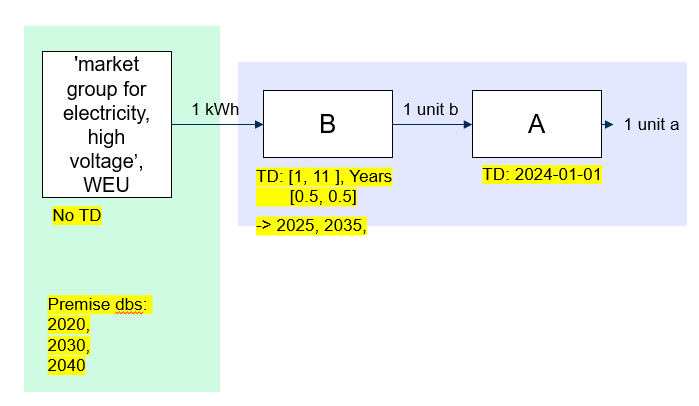
<br> <br> 

write foreground db:

In [59]:
bd.Database('foreground').write({
    ('foreground', 'A'): {
        'name': 'process A',
        "reference product": "a",
        "location": "GLO",
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('foreground', 'A'),
            },
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('foreground', 'B'),
                'temporal_distribution': TemporalDistribution(
                    np.array([1, 11], dtype='timedelta64[Y]'),
                    np.array([0.5, 0.5]
)),  
            },
        ]
    },
    ('foreground', 'B'):
    {
        "name": "process B",
        "reference product": "b",
        "location": "GLO",
        "exchanges": [
             {
                'amount': 1,
                'type': 'technosphere',
                'input': ('bg_2020', 'electr'), # market group for electricity, high voltage' (kilowatt hour, WEU, None)
                                          }
        ]

    },
})

100%|██████████| 2/2 [00:00<00:00, 1978.45it/s]

Vacuuming database 


In [60]:
# checking foreground links
for act in bd.Database('foreground'):
    print(act, act["reference product"])
    for exc in act.technosphere():
        print(exc, exc.input["database"])
       

'process A' (None, GLO, None) a
Exchange: 1 None 'process B' (None, GLO, None) to 'process A' (None, GLO, None)> foreground
'process B' (None, GLO, None) b
Exchange: 1 None 'electricity, high voltage' (None, WEU, None) to 'process B' (None, GLO, None)> bg_2020


select method:

In [61]:
CC_method = [m for m in bd.methods if 'IPCC 2021' in str(m) and  'climate change no LT' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
CC_method

('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

### Standard medusa LCA from here on:

In [62]:
from datetime import datetime

database_date_dict = {
    "bg_2020": datetime.strptime("2020", "%Y"),
    "bg_2030": datetime.strptime("2030", "%Y"),
    "bg_2040": datetime.strptime("2040", "%Y"),

    "db_2020": datetime.strptime("2020", "%Y"), # all databases need to have a corresponding time
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "cutoff39": datetime.strptime("2020", "%Y"),
    
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [63]:
SKIPPABLE = [node.id for node in bd.Database('db_2020')] + [
    node.id for node in bd.Database('db_2030')] + [
    node.id for node in bd.Database('db_2040')] + [
    node.id for node in bd.Database('cutoff39')
    ] 

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

len(SKIPPABLE)

93570

In [64]:
demand = {("foreground",'A'): 1}
slca=bc.LCA(demand,CC_method)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 0.3457984706911323


In [65]:
from timex_lca import MedusaLCA
demand = {('foreground', 'A'): 1}
method = CC_method
mlca = MedusaLCA(demand, method, None, database_date_dict, max_calc=2) #aborted after 100 min for max_calc = 5000


Starting graph traversal
Calculation count: 2


In [66]:
import warnings
warnings.filterwarnings("ignore")
mlca.build_timeline()

,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2024,98285,2024-01-01,98283,process A,2024,-1,2024-01-01,-1,-1,1.0,"{'cutoff39': 0.6000547495209416, 'db_2030': 0...."
1,2025,98286,2025-01-01,98284,process B,2024,98285,2024-01-01,98283,process A,0.5,"{'cutoff39': 0.4998631261976457, 'db_2030': 0...."
2,2025,98287,2025-01-01,98280,"electricity, high voltage",2025,98286,2025-01-01,98284,process B,1.0,"{'cutoff39': 0.4998631261976457, 'db_2030': 0...."
3,2035,98288,2035-01-01,98284,process B,2024,98285,2024-01-01,98283,process A,0.5,"{'db_2030': 0.5, 'db_2040': 0.5}"
4,2035,98289,2035-01-01,98280,"electricity, high voltage",2035,98288,2035-01-01,98284,process B,1.0,"{'db_2030': 0.5, 'db_2040': 0.5}"


In [67]:
mlca.build_datapackage()
mlca.lci()
mlca.lcia()

UnknownObject: 

In [ ]:
for name in ["bg_2020", "bg_2030", "bg_2040", "foreground"]:	
    db = bd.Database(name)
    for act in db:
        print(act["name"], act["database"], act["reference product"], act["location"])
# 112                 "database": database,
#     113                 "name": previous_producer_node["name"],
#     114                 "product": previous_producer_node["reference product"],
#     115                 "location": previous_producer_node["location"],

electricity, from premise bg_2020 electricity, high voltage WEU
electricity, from premise bg_2030 electricity, high voltage WEU
electricity, from premise bg_2040 electricity, high voltage WEU
process B foreground b GLO
process A foreground a GLO


In [ ]:
print('Old static LCA Score:', mlca.static_lca.score)
print('New MEDUSA LCA Score:', mlca.score)

In [ ]:
mlca.dynamic_inventory

compare with prospective-dynamic score with expected results

In [ ]:
# compare with expected results: tiny deviation is fine!

# expected lca results from 1 kWh electricty WEU 2020
lca_electr_WEU_2020=bc.LCA({(electr_WEU_2020["database"],electr_WEU_2020["code"]): 1},CC_method)
lca_electr_WEU_2020.lci()
lca_electr_WEU_2020.lcia()
score_2020 = lca_electr_WEU_2020.score

# expected lca results from 1 kWh electricty WEU 2030
lca_electr_WEU_2030=bc.LCA({(electr_WEU_2030["database"],electr_WEU_2030["code"]): 1},CC_method)
lca_electr_WEU_2030.lci()
lca_electr_WEU_2030.lcia()
score_2030 = lca_electr_WEU_2030.score

# expected lca results from 1 kWh electricty WEU 2040
lca_electr_WEU_2040=bc.LCA({(electr_WEU_2040["database"],electr_WEU_2040["code"]): 1},CC_method)
lca_electr_WEU_2040.lci()
lca_electr_WEU_2040.lcia()
score_2040 = lca_electr_WEU_2040.score

#expected score according to temporal distributions
expected_score=0.5*(0.5*score_2020+0.5*score_2030) + 0.5*(0.5*score_2030+0.5*score_2040)
delta=expected_score-mlca.score
print(f"Difference between medusa score and expected score {delta}")

Difference between medusa score and expected score 2.1680213180275132e-11
